<a href="https://colab.research.google.com/github/nguyetha79/Twitter-Hate-Speech-Detection/blob/main/TwitterHateSpeechDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Import Libraries**

In [ ]:
!pip install datasets
!pip install tweet-preprocessor

### Import EDA Packages

In [ ]:
from datasets import load_dataset
import pandas as pd
import numpy as np

### Import Data Visualization Packages

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import style
style.use('ggplot')
from wordcloud import WordCloud

### Import Machine Learning Packages

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

### Import Pre-Processing Data Packages

In [ ]:
import re
import preprocessor as p
# import string
# import nltk
# from nltk.util import pr
# stemmer = nltk.SnowballStemmer("english")
# nltk.download('stopwords')
# from nltk.corpus import stopwords
# stopword = set(stopwords.words("english"))

## Data Exploration (Exploratory Data Analysis)

In [ ]:
tweet_dataset = load_dataset('hate_speech_offensive')

In [ ]:
tweet_dataset

DatasetDict({
    train: Dataset({
        features: ['count', 'hate_speech_count', 'offensive_language_count', 'neither_count', 'class', 'tweet'],
        num_rows: 24783
    })
})

In [ ]:
tweet_train_dataset = tweet_dataset['train']

In [ ]:
tweet_train_df =  tweet_train_dataset.to_pandas()
tweet_train_df.head()

,count,hate_speech_count,offensive_language_count,neither_count,class,tweet
0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


In [ ]:
tweet_train_df['labels'] = tweet_train_df['class'].map({0:"Hate speech detected", 1:"Offensive language detected", 2:"No hate and offensive speech"})
tweet_train_df.head()

,count,hate_speech_count,offensive_language_count,neither_count,class,tweet,labels
0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...,No hate and offensive speech
1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...,Offensive language detected
2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...,Offensive language detected
3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...,Offensive language detected
4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...,Offensive language detected


In [ ]:
tweet_train_df = tweet_train_df[['tweet', 'labels']]
tweet_train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24783 entries, 0 to 24782
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   tweet   24783 non-null  object
 1   labels  24783 non-null  object
dtypes: object(2)
memory usage: 387.4+ KB


## Data cleaning

In [ ]:
# set up punctuations we want to be replaced
REPLACE_NO_SPACE = re.compile("(\.)|(\;)|(\:)|(\!)|(\')|(\?)|(\,)|(\")|(\|)|(\()|(\))|(\[)|(\])|(\<)|(\>)|(\{)|(\})|(\%)|(\$)|(\&)|(rt)")
REPLACE_WITH_SPACE = re.compile("(<br\s/><br\s/?>)|(-)|(/)|(:).")

In [ ]:
# custom function to clean the dataset
def clean_tweets(df):
  tempArr = []
  for line in df:
    # send to tweet_processor
    text = p.clean(line)
    # remove puctuation
    text = REPLACE_NO_SPACE.sub("", text.lower()) # convert all tweets to lower cases
    text = REPLACE_WITH_SPACE.sub(" ", text)
    # text = [word for word in text.split(' ') if word not in stopword]
    # text = " ".join(text)
    # text = [stemmer.stem(word) for word in text.split(' ')]
    # text = " ".join(text)
    tempArr.append(text)
  return tempArr

In [ ]:
tweet_train_df['tweet'] = clean_tweets(tweet_train_df['tweet'])
tweet_train_df.head(10)

,tweet,labels
0,as a woman you shouldnt complain about clea...,No hate and offensive speech
1,boy dats coldtyga dwn bad for cuffin dat ho...,Offensive language detected
2,dawg you ever fuck a bitch and she sta to ...,Offensive language detected
3,she look like a tranny,Offensive language detected
4,the shit you hear about me might be true or...,Offensive language detected
5,the shit just blows meclaim you so faithful a...,Offensive language detected
6,i can not just sit up and hate on another bit...,Offensive language detected
7,cause im tired of you big bitches coming for ...,Offensive language detected
8,amp you might not get ya bitch back amp thats...,Offensive language detected
9,hobbies include fighting mariambitch,Offensive language detected


## Data Visualization

<Axes: xlabel='labels', ylabel='count'>

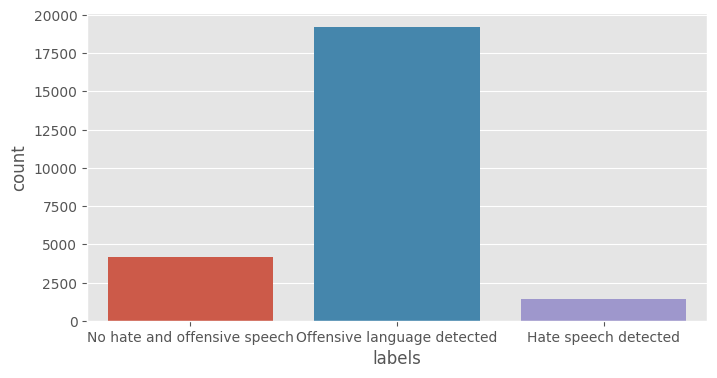

In [ ]:
fig = plt.figure(figsize=(8,4))
sns.countplot(x='labels', data = tweet_train_df)

Text(0.5, 1.0, 'Distribution of sentiments')

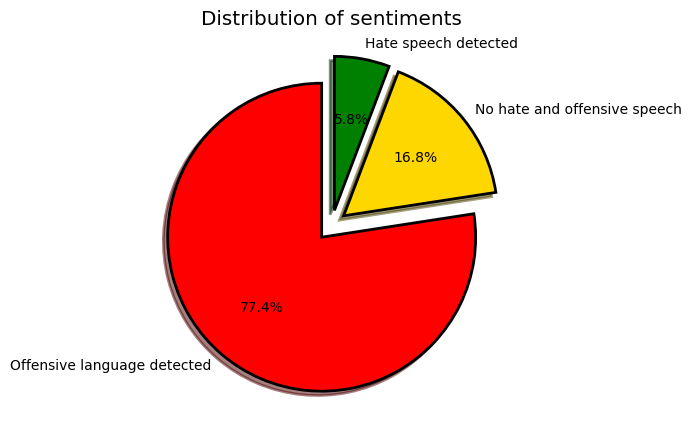

In [ ]:
fig = plt.figure(figsize=(5,5))
colors = ("red", "gold", "green")
wp = {'linewidth':2, 'edgecolor':"black"}
tags = tweet_train_df['labels'].value_counts()
explode = (0.1, 0.1, 0.1)
tags.plot(kind='pie',autopct = '%1.1f%%', shadow=True, colors = colors, startangle =90,
         wedgeprops = wp, explode = explode, label='')
plt.title('Distribution of sentiments')

In [ ]:
offensive_tweets = tweet_train_df[tweet_train_df.labels == 'Offensive language detected']
offensive_tweets.head()

,tweet,labels
1,boy dats coldtyga dwn bad for cuffin dat ho...,Offensive language detected
2,dawg you ever fuck a bitch and she sta to ...,Offensive language detected
3,she look like a tranny,Offensive language detected
4,the shit you hear about me might be true or...,Offensive language detected
5,the shit just blows meclaim you so faithful a...,Offensive language detected


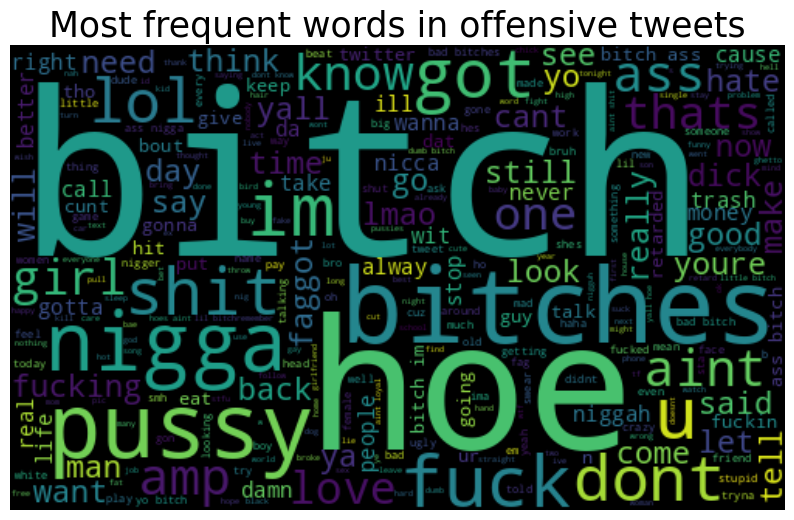

In [ ]:
text = ' '.join([word for word in offensive_tweets['tweet']])
plt.figure(figsize=(10, 15), facecolor='None')

wordcloud = WordCloud(max_words=500, width=500, height=300).generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Most frequent words in offensive tweets', fontsize = 25)
plt.show()

## Features extraction


In [ ]:
cv = CountVectorizer(ngram_range = (1,2))
matrix = cv.fit_transform(tweet_train_df['tweet'])

In [ ]:
feature_names = cv.get_feature_names_out()
print("Number of features: {}\n".format(len(feature_names)))
print("First 20 features: \n{}".format(feature_names[:20]))

Number of features: 153465

First 20 features: 
['00' '00 burg' '00 pm' '003' '00am' '00am not' '00pm' '00pm proof' '01'
 '01 is' '0221' '05' '05 of' '06' '06 left' '07' '07 am' '09' '09 that'
 '10']


## Model building

In [ ]:
x = np.array(tweet_train_df['tweet'])
y = np.array(tweet_train_df['labels'])
x = cv.fit_transform(x)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=42)
print("Size of x_train:", (X_train.shape))
print("Size of y_train:", (y_train.shape))
print("Size of x_test: ", (X_test.shape))
print("Size of y_test: ", (y_test.shape))

Size of x_train: (16604, 153465)
Size of y_train: (16604,)
Size of x_test:  (8179, 153465)
Size of y_test:  (8179,)


In [ ]:
clf = DecisionTreeClassifier()
clf.fit(X_train, y_train)
clf_predict = clf.predict(X_test)

## Evaluation

In [ ]:
clf_acc = accuracy_score(clf_predict, y_test)
print("Test accuarcy: {:.2f}%".format(clf_acc*100))

Test accuarcy: 88.01%


In [ ]:
print(confusion_matrix(y_test, clf_predict))
print("\n")
print(classification_report(y_test, clf_predict))

[[ 137   45  283]
 [  30 1164  185]
 [ 207  231 5897]]


                              precision    recall  f1-score   support

        Hate speech detected       0.37      0.29      0.33       465
No hate and offensive speech       0.81      0.84      0.83      1379
 Offensive language detected       0.93      0.93      0.93      6335

                    accuracy                           0.88      8179
                   macro avg       0.70      0.69      0.69      8179
                weighted avg       0.87      0.88      0.88      8179



<Axes: >

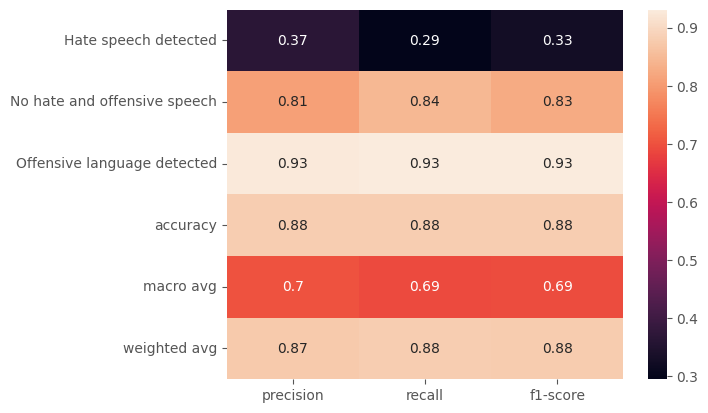

In [ ]:
clf_report = classification_report(y_test, clf_predict, output_dict=True)
sns.heatmap(pd.DataFrame(clf_report).iloc[:-1, :].T, annot=True)

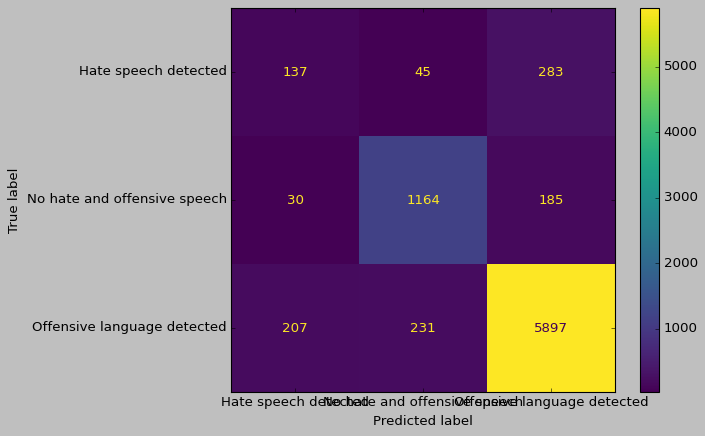

In [ ]:
style.use('classic')
cm = confusion_matrix(y_test, clf_predict, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot()

In [ ]:
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings('ignore')

In [ ]:
param_grid = { 'criterion':['gini','entropy'],'max_depth': [None, 5, 10, 15]}
grid = GridSearchCV(estimator=clf, param_grid=param_grid, cv = 7)
grid.fit(X_train, y_train)
print("Best Cross validation score: {:.2f}".format(grid.best_score_))
print("Best parameters: ", grid.best_params_)

Best Cross validation score: 0.88
Best parameters:  {'criterion': 'gini', 'max_depth': None}


In [ ]:
y_pred = grid.predict(X_test)

In [ ]:
clf_acc = accuracy_score(y_pred, y_test)
print("Test accuracy: {:.2f}%".format(clf_acc*100))

Test accuracy: 88.08%


In [ ]:
print(confusion_matrix(y_test, y_pred))
print("\n")
print(classification_report(y_test, y_pred))

[[ 133   47  285]
 [  32 1164  183]
 [ 203  226 5906]]


                              precision    recall  f1-score   support

        Hate speech detected       0.36      0.29      0.32       465
No hate and offensive speech       0.81      0.84      0.83      1379
 Offensive language detected       0.93      0.93      0.93      6335

                    accuracy                           0.88      8179
                   macro avg       0.70      0.69      0.69      8179
                weighted avg       0.87      0.88      0.88      8179



## Using Model

In [ ]:
def cover_hate_speech(cv, data):
  df = cv.transform([data]).toarray()
  result = clf.predict(df)
  print(result[0])

  if result[0] == 'Offensive language detected' or result[0] == 'Hate speech detected':
    print('Original speech should be covered:')
    for k in range(len(result[0])):
      print('*', end='')
  else:
      print('Original speech: ' + data)

In [ ]:
cover_hate_speech(cv, "I will kill you.")

Hate speech detected
Original speech should be covered:
********************

In [ ]:
cover_hate_speech(cv, "You are awesome")

No hate and offensive speech
Original speech: You are awesome
